<a href="https://colab.research.google.com/github/singr7/MIRAutoencoder/blob/master/DolphinCRNNAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import * 
from tensorflow.keras.losses import * 


def encoder(in_shape, latent_dim, conv_params):
    """
    A LSTM stack on top of a convolutional layer pooled in time.
    :param in_shape: the input shape to the model
    :param latent_dim: embedding size of the model
    :param conv_params: (conv_w, conv_h, filters)
    :returns: a keras model
    """
    kernel_size = (conv_params[0], conv_params[1])
    n_filters = conv_params[2]
    dft_dim = in_shape[1]
    inp = Input(in_shape)
    loc = Conv2D(n_filters, strides = (1, 1), kernel_size=kernel_size, activation='relu', padding='same')(inp) # Shape (Time, DFT, Filters)
    loc = MaxPool2D(pool_size=(1, dft_dim))(loc) # Pool in time (Time, DFT, Filters) -> (Time, 1, Filters)
    loc = Reshape((in_shape[0], n_filters))(loc) # Reshape for temporal model (Time, 1, Filters)  -> (Time, Filters)
    x   = BatchNormalization()(loc)
    x   = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x   = LSTM(latent_dim)(x)            
    return Model(inputs =[inp], outputs=[x])


def decoder(length, latent_dim, output_dim, conv_params):
    """
    A LSTM stack followed by a de-convolution layer to reconstruct the input
    :param length: length of the sequence to reconstruct
    :param latent_dim: dimension of the latent space we reconstruct from
    :param output_dim: dimension of output
    :param conv_params: (conv_w, conv_h, filters)
    :returns: a keras model
    """
    kernel_size = (conv_params[0], conv_params[1])
    n_filters = conv_params[2]

    inp = Input((latent_dim))
    x   = Reshape((1, latent_dim))(inp)
    x   = ZeroPadding1D((0, length - 1))(x)
    x   = LSTM(latent_dim, return_sequences=True)(x)    
    x   = Bidirectional(LSTM(output_dim // 2, return_sequences=True))(x)
    x   = Reshape((length, output_dim, 1))(x)
    x   = Conv2DTranspose(n_filters, kernel_size=kernel_size, activation='relu', padding='same')(x) 
    x   = Conv2DTranspose(1, kernel_size=(1, 1), activation='linear', padding='same')(x) 
    return Model(inputs = [inp], outputs = [x])


def auto_encoder(in_shape, latent_dim, conv_params):
    """
    Auto encoder from encoder / decoder architecture on top of
    convolution / deconvolution layers
    See Figure [KOH4] Figure 2.
    :param in_shape: input shape (time, dimensions, 1)
    :param latent_dim: the length of the embedding vector
    :param conv_params: (conv_w, conv_h, filters)
    :returns: a keras model for the auto encoder and a separate for the encoder
    """
    enc = encoder(in_shape, latent_dim, conv_params)
    dec = decoder(in_shape[0], latent_dim, in_shape[1], conv_params)
    inp = Input(in_shape)
    x   = enc(inp) 
    x   = dec(x) 
    model = Model(inputs = [inp], outputs = [x])
    model.compile(optimizer = RMSprop(), loss='mse')
    return model, enc

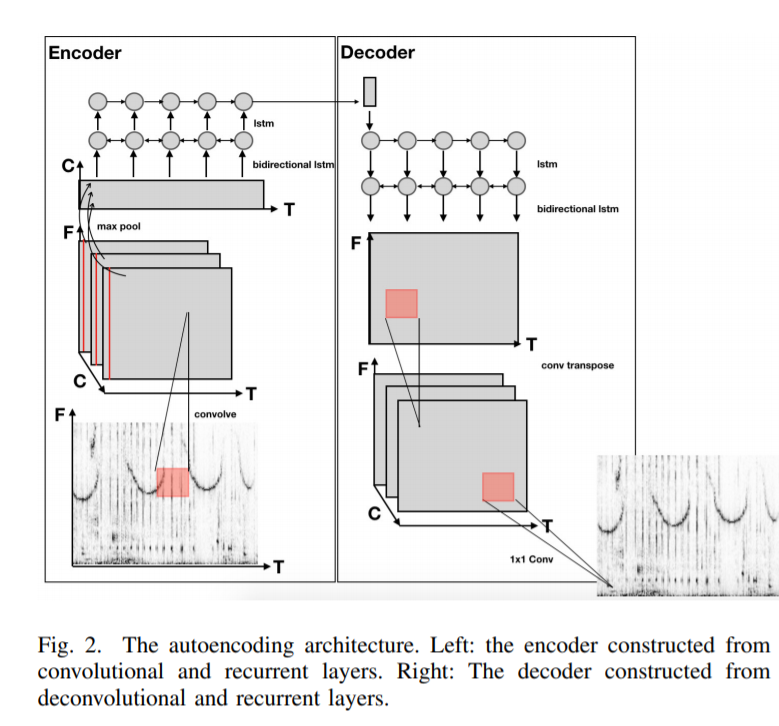

In [ ]:
# feature extractor


In [ ]:
# audio preprocessing

def read(first_channel=True):
    """
    Read an audio file from local file system or cloud storage
    all all formats that ffmpeg supports are supported
    :param path: pathlike object
    :param first_channel: if true take the first channel for multi channel audio, if false average all channels 
    :returns: audio file with shape (time, )
    """
    import numpy as np 
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    import os
    files = []
    exclusion = ["098567.npy","098569.npy", '098565.npy']
    for r,d, fileList in os.walk("/content/drive/My Drive/MusicResearchColabNB/Western_numpy"):
      for file in fileList:
        if(file not in exclusion):
          files.append(os.path.join(r,file))
        else:
          pass
          #print(file)

    return files


In [ ]:
files=read()

Mounted at /content/drive


In [ ]:
for f in files:
    x = np.load(f)
    print(x.shape[0], x.shape[1], x.shape)
    x = x[:,:200]
    print(x.shape[0], x.shape[1], x.shape)
    break

26 400 (26, 400)
26 200 (26, 200)


In [ ]:
#windowsparam function

from collections import namedtuple

class WindowParams(namedtuple('WindowParams', 'spec_win spec_step fft_win fft_step highpass')):

    @property
    def n_fft_bins(self):
        return self.fft_win // 2

    @property
    def fft_win_filtered(self):
        """
        Pad the FFT window by the highpass so the target dimension stays the same
        """
        return self.fft_win + 2 * self.highpass

    @property
    def win_len(self):
        """
        Length of the spectrogram window returned in audio samples
        """
        return self.spec_win * self.fft_step + self.fft_win_filtered

    @property
    def step(self):
        """
        Step size of spectrogram window in audio samples
        """
        return self.spec_step * self.fft_step

    def range(self, sample):
        """
        The range of a sample in a spectrogam window in the audio file
        :param sample: a sample in the spectrogram window
        :returns: start sample in raw audio, stop sample in raw audio
        """
        start_audio = sample * self.step
        stop_audio  = start_audio + self.win_len
        return start_audio, stop_audio

    def len(self, audio_samples):
        """
        Compute the number of spectrogram window in an audio file
        :param audio_samples: number of audio samples in audio_file
        :returns: length of the window
        """
        return (audio_samples - self.win_len) // self.step + 1

In [ ]:
import sys
import yaml
import glob
import numpy as np
import subprocess  
import os
import datetime
import tensorflow as tf
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import multiprocessing as mp
import re
import logging
logging.basicConfig()
log = logging.getLogger('main')
log.setLevel(logging.INFO)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from tensorflow.keras.backend import set_learning_phase
from tensorflow.keras.models import load_model
#from feature_extractor import *
from sklearn.cluster import *

#from plots import *
#from audio_collection import *
#from audio import * 


def train(folder, output_folder, params, enc, ae, batch_size=10, epochs=50, keep=lambda x: True):
    """
    Train the model for some epochs with a specific batch size
    :param data: a data iterator
    :param model: a keras model
    :param batch_size: size of the mini batch
    :param epochs: number of runs over the complete dataset
    :param keep: function from label to keep or not
    """
    n_processed = 0
    training_log = open('{}/loss.csv'.format(output_folder), 'w') 
    files= read()
    for epoch in range(epochs):
        batch = []
        epoch_loss = 0.0

        for f in files[:2008]:
            x = np.load(f)
            x= x[:,:200]
            batch.append(x)
            total_loss = 0.0
            if len(batch) == batch_size:
                x = np.stack([x.reshape(x.shape[0], x.shape[1], 1) for x in batch])
                loss = ae.train_on_batch(x=x, y=x)
                total_loss += loss
                batch = []
                if n_processed % 10 == 0:
                    log.info("#: {} EPOCH: {} LOSS: {}".format(n_processed, epoch, total_loss))
                    total_loss = 0.0
                n_processed += 1
                epoch_loss += loss

        training_log.write('{},{},{}\n'.format(epoch, n_processed, epoch_loss))
        #training_log.flush()
    #training_log.close()
    

def train_auto_encoder(version_tag, input_folder, output_folder, params, latent, batch, epochs, conv_param):
    """
    Train an auto encoder for feature embedding
    :param version_tag: basically the model name
    :param input_folder: the folder with the training data
    :param output_folder: the folder to save the model
    :param noise_folder: folder some files with only noise for data augmentation
    :param params: window parameters
    :param latent: dimension of the latent space
    :param batch: batch size
    :param epochs: number of training epochs
    :param conv_params: (conv_w, conv_h, filters)
    """
    log.info("Training Auto Encoder: {}".format(version_tag))
 
 #   ae, enc = auto_encoder(
 #       (params.spec_win, params.n_fft_bins, 1), latent, conv_param
  #  )
# Change it from 400 to 200 as 400 is quite high...
    ae, enc = auto_encoder(
        (26, 200, 1), latent, conv_param
    )
    enc.summary()
    if os.path.exists('{}/encoder.h5'.format(output_folder)) and os.path.exists('{}/auto_encoder.h5'.format(output_folder)):
        print('########## here')
        log.info("\tloading previous weights")
        _enc = load_model('{}/encoder.h5'.format(output_folder))
        _enc.summary()
        _ae  = load_model('{}/auto_encoder.h5'.format(output_folder))
        enc.set_weights(_enc.get_weights())
        ae.set_weights(_ae.get_weights())
    w_before = enc.layers[1].get_weights()[0].flatten()
    train(input_folder, output_folder, params, enc, ae, batch, epochs)
    w_after = enc.layers[1].get_weights()[0].flatten()
    #log.info("DELTA W:", np.sum(np.square(w_before - w_after)))
    enc.save('{}/encoder_reconstruction.h5'.format(output_folder), include_optimizer=False)
    enc.save('{}/encoder.h5'.format(output_folder), include_optimizer=False)
    ae.save('{}/auto_encoder.h5'.format(output_folder), include_optimizer=False)

    

#def evaluate_encoder(version_tag, input_folder, output_folder, encoder_file, params, min_support=5):


def header():
    return """
    =================================================================
    CRNN autoencoder Machine Learning Pipeline
                
    usage: python ml_pipeline/pipeline.py config/default_config.yaml
    
    =================================================================
    """


if __name__== "__main__":
    log.info(header())
#    c = yaml.load(open(sys.argv[1]))
#    log.info("Parameters: {}".format(c))
#    version      = c['version']
    version      = "version_1"

        # spectrogram parameters
    params       = WindowParams(32, 16, 512, 64, 10)
        
        # neural parameters
    latent          = 128
    batch           = 20
    epochs          = 10 # c['epochs']
    conv_param      = (8,  8,  64)   #(c['conv_w'],  c['conv_h'],  c['conv_filters'])
        
        # datasets
    unsupervised = 'CRNN/'
    output       = '/content/drive/My Drive/MusicResearchColabNB/CRNN/models/output/'

        # clutering paams
    log.info("Mixed Training Epoch AE")
    train_auto_encoder(version, unsupervised, output, params, latent, batch, epochs, conv_param)
        #evaluate_encoder(version, unsupervised, output, "{}/encoder.h5".format(output), params)       
        #test_reconstruction(unsupervised, output, params)

INFO:main:
    CRNN autoencoder Machine Learning Pipeline
                
    usage: python ml_pipeline/pipeline.py config/default_config.yaml
    
    
INFO:main:Mixed Training Epoch AE
INFO:main:Training Auto Encoder: version_1
INFO:main:	loading previous weights


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 26, 200, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 200, 64)       4160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 1, 64)         0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 26, 64)            0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 26, 64)            256       
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 26, 256)           197632    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               197

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 26, 200, 1)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 200, 64)       4160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 1, 64)         0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 26, 64)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 64)            256       
_________________________________________________________________
bidirectional_8 (Bidirection (None, 26, 256)           197632    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               197

Mounted at /content/drive


INFO:main:#: 0 EPOCH: 0 LOSS: 78.1390609741211
INFO:main:#: 10 EPOCH: 0 LOSS: 56.90215301513672
INFO:main:#: 20 EPOCH: 0 LOSS: 49.421382904052734
INFO:main:#: 30 EPOCH: 0 LOSS: 85.10538482666016
INFO:main:#: 40 EPOCH: 0 LOSS: 76.35948181152344
INFO:main:#: 50 EPOCH: 0 LOSS: 85.49740600585938
INFO:main:#: 60 EPOCH: 0 LOSS: 69.54645538330078
INFO:main:#: 70 EPOCH: 0 LOSS: 86.83642578125
INFO:main:#: 80 EPOCH: 0 LOSS: 84.42658996582031
INFO:main:#: 90 EPOCH: 0 LOSS: 65.58666229248047
INFO:main:#: 100 EPOCH: 1 LOSS: 78.13788604736328
INFO:main:#: 110 EPOCH: 1 LOSS: 58.48612594604492
INFO:main:#: 120 EPOCH: 1 LOSS: 51.23499298095703
INFO:main:#: 130 EPOCH: 1 LOSS: 82.0538330078125
INFO:main:#: 140 EPOCH: 1 LOSS: 74.31314086914062
INFO:main:#: 150 EPOCH: 1 LOSS: 80.84834289550781
INFO:main:#: 160 EPOCH: 1 LOSS: 73.0484848022461
INFO:main:#: 170 EPOCH: 1 LOSS: 78.71563720703125
INFO:main:#: 180 EPOCH: 1 LOSS: 87.84536743164062
INFO:main:#: 190 EPOCH: 1 LOSS: 68.07547760009766
INFO:main:#: 200